In [ ]:
#!/usr/bin/env python3
"""
compare_wave_load.py

This script compares the QTF matrices computed by the NumPy-based and JAX-based
wave load implementations. It initializes both versions with the same wave
parameters and vessel configuration, extracts the QTF matrices, computes the
difference, and then displays basic statistics along with plots for a visual
comparison of a representative slice.
"""

import numpy as np
import matplotlib.pyplot as plt
import json
import time
# Ensure the x-axis data matches the shape of the y-axis data
# Interpolate qtf_angles_deg to match the shape of the RAO amplitude arrays
from scipy.interpolate import interp1d

# --- Import the NumPy version of wave load ---
from mclsimpy.waves import WaveLoad as NumpyWaveLoad

# --- Import the JAX version of wave load and required packages ---
import jax
import jax.numpy as jnp
from jax_core.simulator.waves.wave_load_jax_jit import init_wave_load as init_jax_wave_load
from jax_core.simulator.waves.wave_load_jax_jit import first_order_loads as jax_first_order_loads 
from jax_core.simulator.waves.wave_load_jax_jit import second_order_loads as jax_second_order_loads
from jax_core.simulator.waves.wave_load_jax_jit import wave_load as jax_wave_load
from jax_core.simulator.waves.wave_load_jax_jit import relative_incident_angle as jax_relative_incident_angle
from jax_core.simulator.waves.wave_load_jax_jit import rao_interp as jax_rao_interp

In [59]:

# ------------------------------
# Set up identical wave parameters
# ------------------------------

# Simulation parameters for wave properties
hs    = 5.0 / 90.0  # Significant wave height [m]
tp    = 17.0 * np.sqrt(1 / 90.0)  # Peak period [s]
gamma = 3.3  # JONSWAP peak factor

wp   = 2 * np.pi / tp   # Peak frequency [rad/s]
wmin = 0.5 * wp
wmax = 3.0 * wp
N    = 100             # Number of wave components

# Generate frequency arrays for NumPy and JAX
freqs_np = np.linspace(wmin, wmax, N)
freqs_jax = jnp.linspace(wmin, wmax, N)

# Dummy wave spectrum data is used (actual spectrum not needed for QTF interpolation)
dw = (wmax - wmin) / N
# Using a dummy spectrum (ones) so that the wave amplitudes are computed similarly;
# note: the QTF computation does not use the amplitudes.
wave_spectrum_np = np.ones(N)
wave_spectrum_jax = jnp.ones(N)
wave_amps_np = np.sqrt(2.0 * wave_spectrum_np * dw)
wave_amps_jax = jnp.sqrt(2.0 * wave_spectrum_jax * dw)

# Fixed phases (linearly spaced) for reproducible results 
# NBNBNB!! not random and not how one would do it normally 
# it should be random.uniform(0, 2*np.pi, N)
rand_phase_np = np.linspace(0, 2 * np.pi, N, endpoint=False)
rand_phase_jax = jnp.linspace(0, 2 * jnp.pi, N, endpoint=False)

# Constant incident wave angles (e.g. 45°)
wave_angles_np = np.ones(N) * (np.pi / 4)
wave_angles_jax = jnp.ones(N) * (jnp.pi / 4)

# Configuration file path (update this path as needed)
config_file = "/home/kmroen/miniconda3/envs/tensor/lib/python3.9/site-packages/mclsimpy/vessel_data/CSAD/vessel_json.json"  # Ensure this file exists and is compatible with both versions



=== Comparing Wave Numbers (k) with deep_water = False ===
***************************************Generate QTF matrices****************************************
Using Newman

***************************************QTF matrices complete.***************************************
NumPy-based (shallow) wave load init time: 0.30 seconds
***************************************Generate QTF matrices****************************************
Using Newman

***************************************QTF matrices complete.***************************************
JAX-based (shallow) wave load init time: 1.42 seconds
Wave Number (k) shapes:
  NumPy: (100,)
  JAX: (100,)
Max absolute difference in k: 1.806646098501119e-06
Mean absolute difference in k: 3.023092231063673e-07


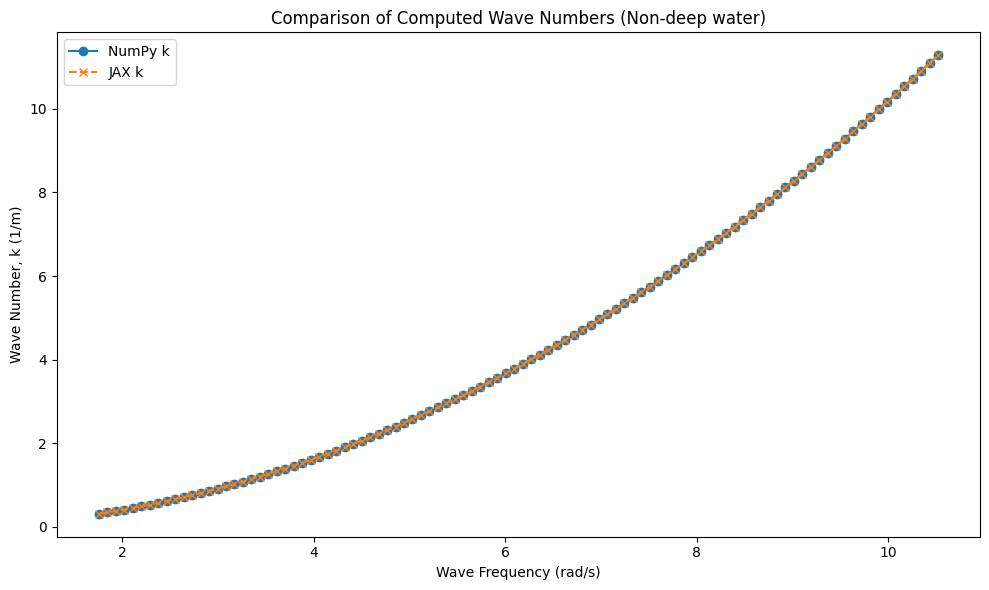

In [60]:

# =============================================================================
# Compare Wave Numbers (k) for non-deep water (iterative scheme)
# =============================================================================
print("\n=== Comparing Wave Numbers (k) with deep_water = False ===")

# Initialize NumPy-based WaveLoad with deep_water=False.
start_time = time.time()
numpy_wl_shallow = NumpyWaveLoad(
    wave_amps=wave_amps_np,
    freqs=freqs_np,
    eps=rand_phase_np,
    angles=wave_angles_np,
    config_file=config_file,
    interpolate=True,
    qtf_method="Newman",
    deep_water=False  # Force iterative wave number calculation
)
print(f"NumPy-based (shallow) wave load init time: {time.time() - start_time:.2f} seconds")

# Initialize JAX-based WaveLoad with deep_water=False.
start_time = time.time()
jax_wl_shallow = init_jax_wave_load(
    wave_amps=wave_amps_jax,
    freqs=freqs_jax,
    eps=rand_phase_jax,
    angles=wave_angles_jax,
    config_file=config_file,
    rho=1025,
    g=9.81,
    dof=6,
    depth=100,
    deep_water=False,  # Force iterative scheme
    qtf_method="Newman",
    qtf_interp_angles=True,
    interpolate=True
)
print(f"JAX-based (shallow) wave load init time: {time.time() - start_time:.2f} seconds")

# In each implementation the wave number, k, is computed during initialization.
# For NumPy, it is stored as _k and for JAX as the field k.
k_numpy = numpy_wl_shallow._k    # NumPy array
k_jax = np.array(jax_wl_shallow.k) # Convert JAX array to NumPy

print("Wave Number (k) shapes:")
print("  NumPy:", k_numpy.shape)
print("  JAX:", k_jax.shape)

# Compare the wave number arrays:
k_diff = np.abs(k_numpy - k_jax)
print("Max absolute difference in k:", np.max(k_diff))
print("Mean absolute difference in k:", np.mean(k_diff))

# Plot the wave numbers for visual inspection.
plt.figure(figsize=(10, 6))
plt.plot(freqs_np, k_numpy, label="NumPy k", marker="o", linestyle="-")
plt.plot(freqs_np, k_jax, label="JAX k", marker="x", linestyle="--")
plt.xlabel("Wave Frequency (rad/s)")
plt.ylabel("Wave Number, k (1/m)")
plt.title("Comparison of Computed Wave Numbers (Non-deep water)")
plt.legend()
plt.tight_layout()
plt.show()

In [61]:
# ------------------------------
# Initialize WaveLoad objects from both implementations
# ------------------------------

# Create NumPy-based wave load instance
start_time = time.time()
numpy_wl_geo = NumpyWaveLoad(
    wave_amps=wave_amps_np,
    freqs=freqs_np,
    eps=rand_phase_np,
    angles=wave_angles_np,
    config_file=config_file,
    interpolate=True,
    qtf_method="geo-mean",
    deep_water=True
)
print(f"NumPy-based wave load init time: {time.time() - start_time:.2f} seconds")

# Create JAX-based wave load instance
start_time = time.time()
jax_wl_geo = init_jax_wave_load(
    wave_amps=wave_amps_jax,
    freqs=freqs_jax,
    eps=rand_phase_jax,
    angles=wave_angles_jax,
    config_file=config_file,
    rho=1025,
    g=9.81,
    dof=6,
    depth=100,
    deep_water=True,
    qtf_method="geo-mean",
    qtf_interp_angles=True,
    interpolate=True
)
print(f"JAX-based wave load init time: {time.time() - start_time:.2f} seconds")
# ------------------------------
# Initialize WaveLoad objects from both implementations
# ------------------------------

# Create NumPy-based wave load instance
start_time = time.time()
numpy_wl_newman = NumpyWaveLoad(
    wave_amps=wave_amps_np,
    freqs=freqs_np,
    eps=rand_phase_np,
    angles=wave_angles_np,
    config_file=config_file,
    interpolate=True,
    qtf_method="Newman",
    deep_water=True
)
print(f"NumPy-based wave load init time: {time.time() - start_time:.2f} seconds")

# Create JAX-based wave load instance
start_time = time.time()
jax_wl_newman = init_jax_wave_load(
    wave_amps=wave_amps_jax,
    freqs=freqs_jax,
    eps=rand_phase_jax,
    angles=wave_angles_jax,
    config_file=config_file,
    rho=1025,
    g=9.81,
    dof=6,
    depth=100,
    deep_water=True,
    qtf_method="Newman",
    qtf_interp_angles=True,
    interpolate=True
)
print(f"JAX-based wave load init time: {time.time() - start_time:.2f} seconds")




***************************************Generate QTF matrices****************************************
Using Geometric mean

***************************************QTF matrices complete.***************************************
NumPy-based wave load init time: 0.57 seconds
***************************************Generate QTF matrices****************************************
Using Geometric mean

***************************************QTF matrices complete.***************************************
JAX-based wave load init time: 1.35 seconds
***************************************Generate QTF matrices****************************************
Using Newman

***************************************QTF matrices complete.***************************************
NumPy-based wave load init time: 0.23 seconds
***************************************Generate QTF matrices****************************************
Using Newman

***************************************QTF matrices complete.************************

In [62]:
# ------------------------------
# Extract the QTF matrices for comparison
# ------------------------------

# For the NumPy version, the QTF is stored as an attribute (_Q)
qtf_np_geo = numpy_wl_geo._Q  # Expected shape: (6, M, N, N) where M is number of QTF interpolation angles

# For the JAX version, Q is a field of the dataclass. Convert to a NumPy array for comparison.
qtf_jax_geo = np.array(jax_wl_geo.Q)

# Print shapes to verify consistency
print("NumPy QTF shape:", qtf_np_geo.shape)
print("JAX QTF shape:", qtf_jax_geo.shape)


# For the Newman method
qtf_np_newman = numpy_wl_newman._Q  # Expected shape: (6, M, N, N) where M is number of QTF interpolation angles
qtf_jax_newman = np.array(jax_wl_newman.Q)
# Print shapes to verify consistency
print("NumPy QTF shape:", qtf_np_newman.shape)
print("JAX QTF shape:", qtf_jax_newman.shape)
# ------------------------------

NumPy QTF shape: (6, 360, 100, 100)
JAX QTF shape: (6, 360, 100, 100)
NumPy QTF shape: (6, 360, 100, 100)
JAX QTF shape: (6, 360, 100, 100)


In [63]:
# ------------------------------
# Compute difference statistics between the QTF matrices
# ------------------------------

diff_geo = np.abs(qtf_np_geo - qtf_jax_geo)
max_diff_geo = np.max(diff_geo)
mean_diff_geo = np.mean(diff_geo)
print("Max absolute difference in QTF matrices:", max_diff_geo)
print("Mean absolute difference in QTF matrices:", mean_diff_geo)

# For the Newman method
diff_newman = np.abs(qtf_np_newman - qtf_jax_newman)
max_diff_newman = np.max(diff_newman)
mean_diff_newman = np.mean(diff_newman)
print("Max absolute difference in QTF matrices:", max_diff_newman)
print("Mean absolute difference in QTF matrices:", mean_diff_newman)
# ------------------------------





Max absolute difference in QTF matrices: 0.016623295875032085
Mean absolute difference in QTF matrices: 8.928231275965337e-05
Max absolute difference in QTF matrices: 0.005349634758204047
Mean absolute difference in QTF matrices: 0.00011756227730168632


The qtf is only for the 3dof. Therefor we do not have any plots for 2,3,4 index

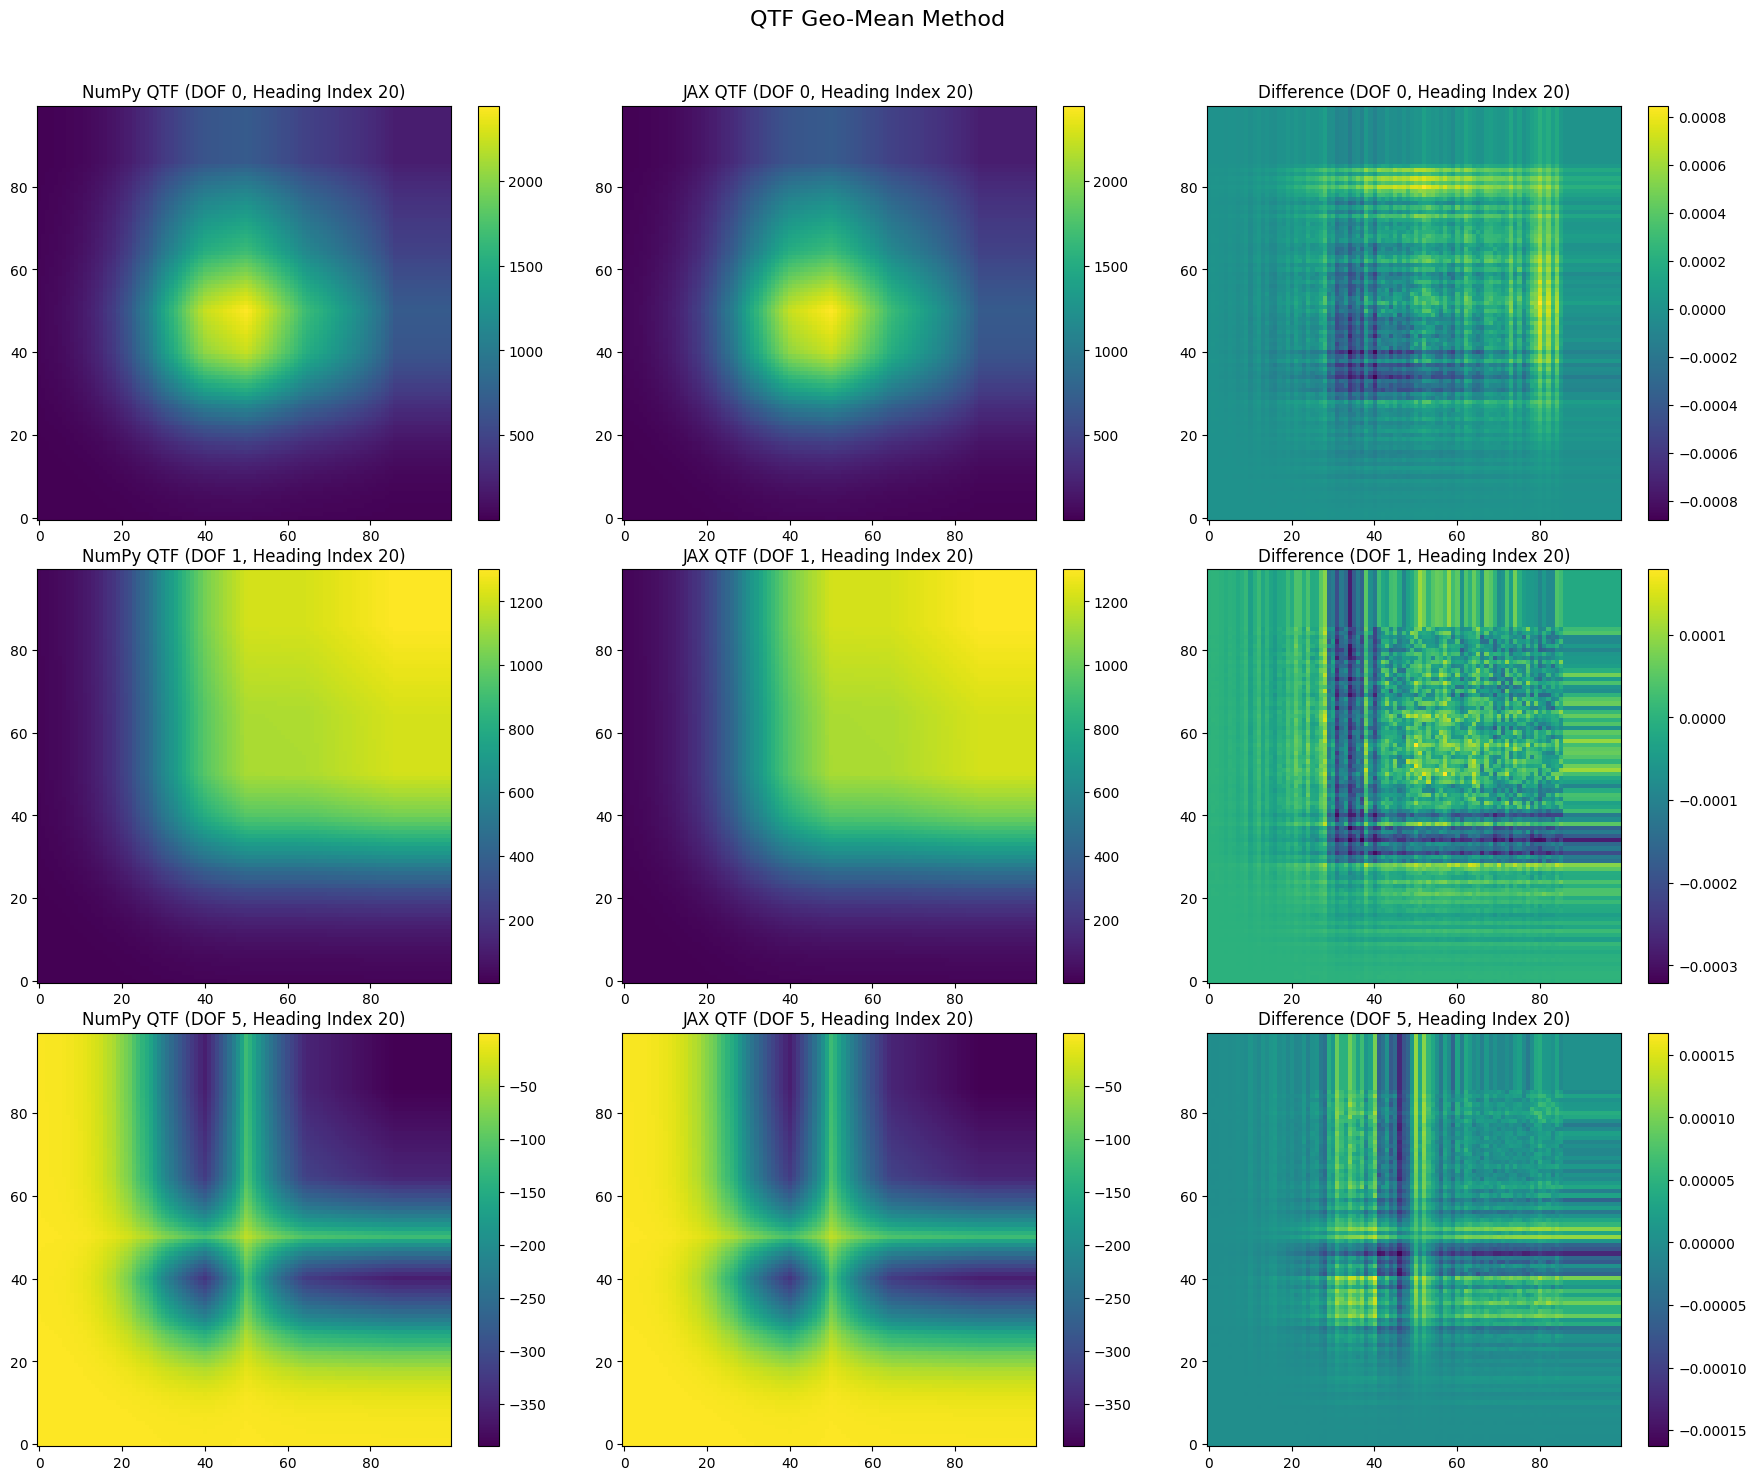

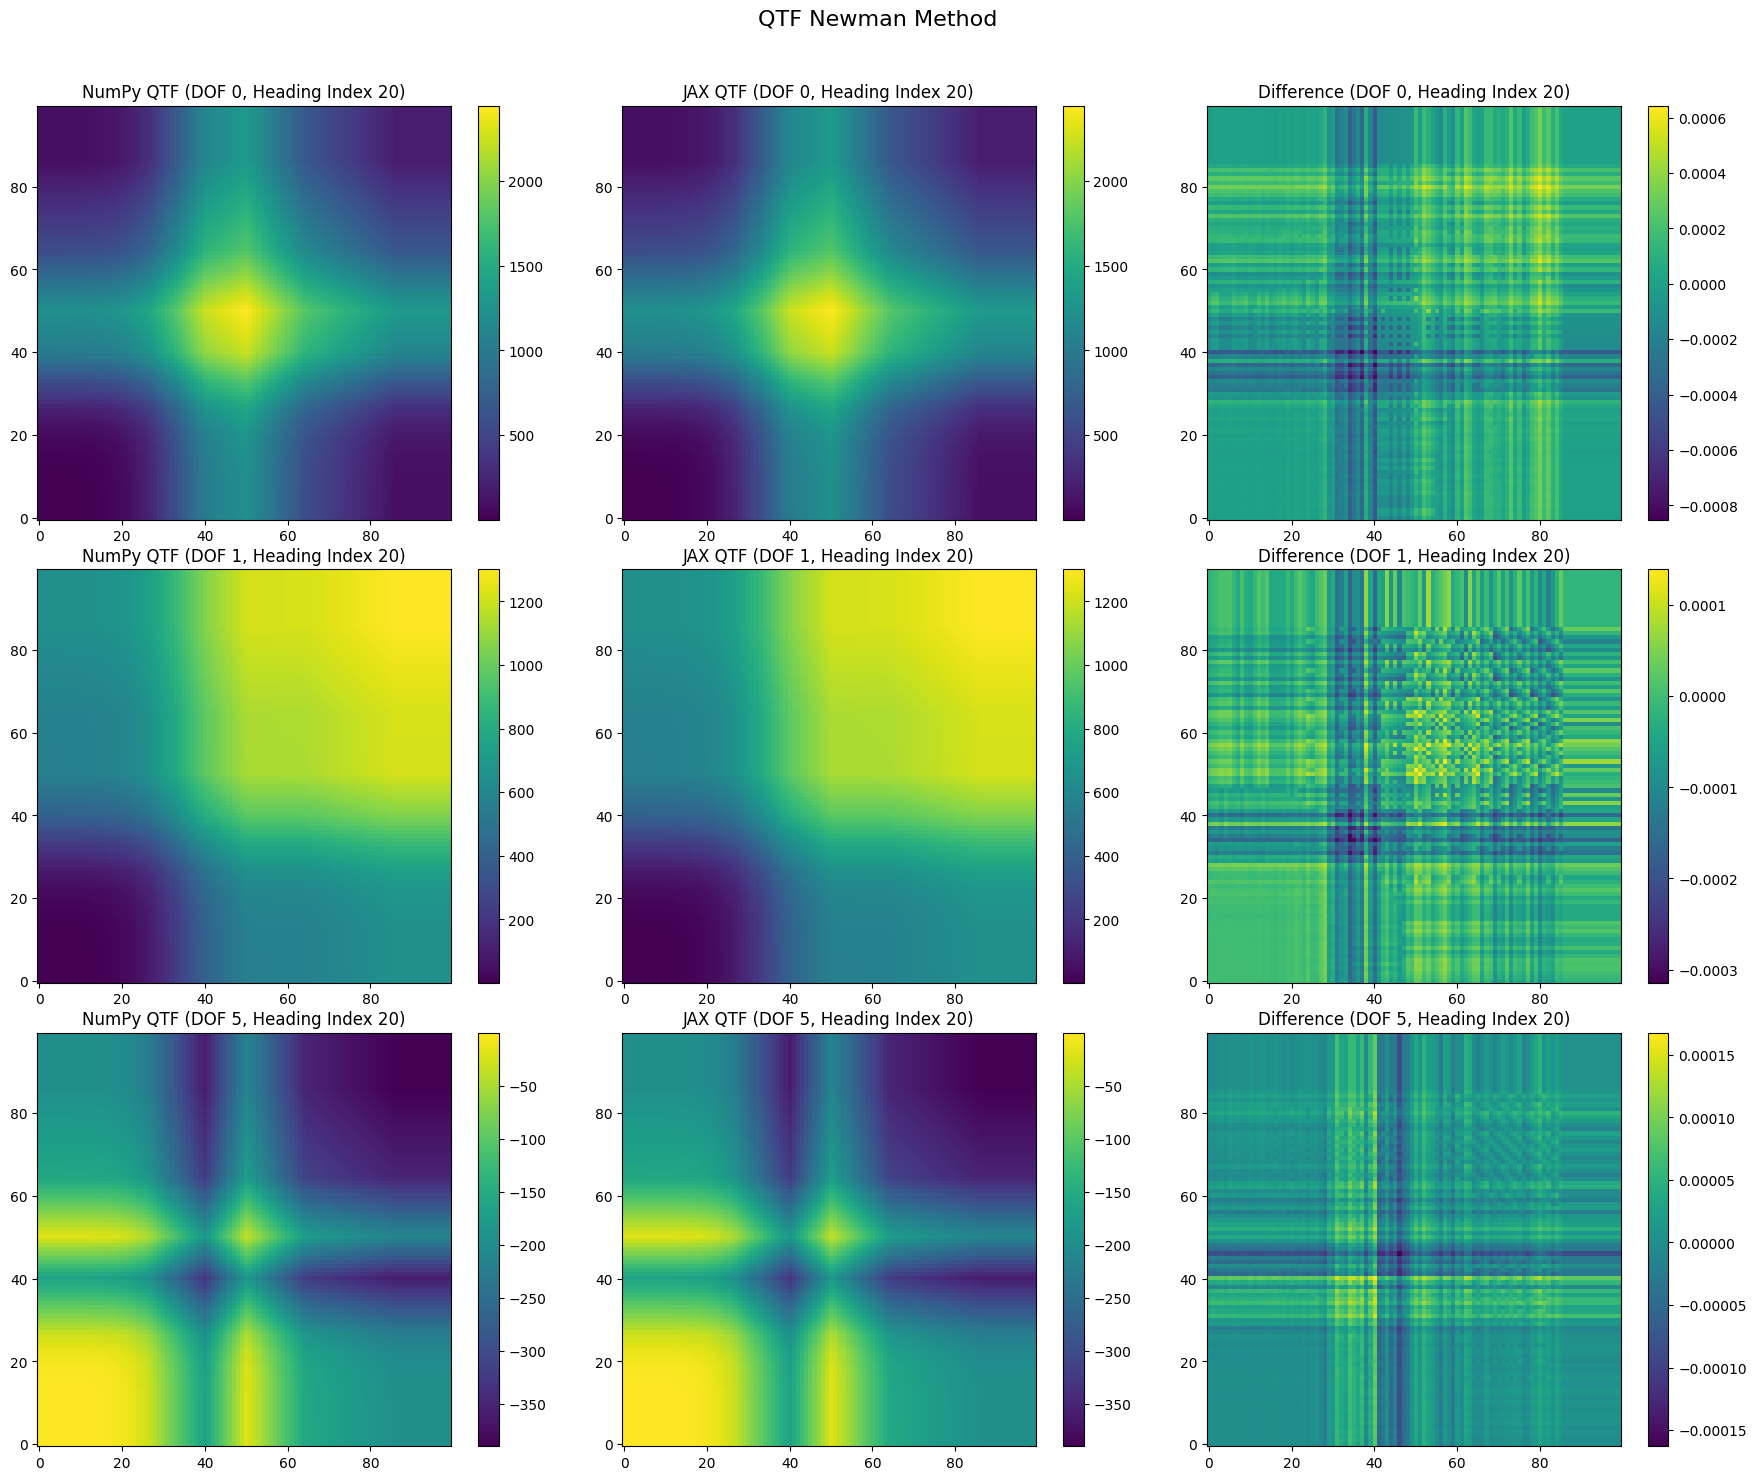

In [64]:
# ------------------------------
# Plot QTF matrices and their differences for all 6 DOFs, skipping DOFs 2, 3, and 4.
# For illustration, we use the first heading index.
# ------------------------------

heading_index = 20  # Heading index to use for all plots

# Geo-mean method
fig, axes = plt.subplots(3, 3, figsize=(18, 15))  # 3 DOFs (0, 1, 5), 3 plots per DOF
plot_dofs = [0, 1, 5]  # DOFs to include in the plots

for i, dof in enumerate(plot_dofs):  # Iterate over selected DOFs
    # NumPy QTF slice
    im0 = axes[i, 0].imshow(qtf_np_geo[dof, heading_index, :, :], origin="lower")
    axes[i, 0].set_title(f"NumPy QTF (DOF {dof}, Heading Index {heading_index})")
    fig.colorbar(im0, ax=axes[i, 0])

    # JAX QTF slice
    im1 = axes[i, 1].imshow(qtf_jax_geo[dof, heading_index, :, :], origin="lower")
    axes[i, 1].set_title(f"JAX QTF (DOF {dof}, Heading Index {heading_index})")
    fig.colorbar(im1, ax=axes[i, 1])

    # Difference (NumPy - JAX)
    im2 = axes[i, 2].imshow(qtf_np_geo[dof, heading_index, :, :] - qtf_jax_geo[dof, heading_index, :, :], origin="lower")
    axes[i, 2].set_title(f"Difference (DOF {dof}, Heading Index {heading_index})")
    fig.colorbar(im2, ax=axes[i, 2])

fig.suptitle("QTF Geo-Mean Method", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit the title
plt.show()

# Newman method
fig, axes = plt.subplots(3, 3, figsize=(18, 15))  # 3 DOFs (0, 1, 5), 3 plots per DOF
for i, dof in enumerate(plot_dofs):  # Iterate over selected DOFs
    # NumPy QTF slice
    im0 = axes[i, 0].imshow(qtf_np_newman[dof, heading_index, :, :], origin="lower")
    axes[i, 0].set_title(f"NumPy QTF (DOF {dof}, Heading Index {heading_index})")
    fig.colorbar(im0, ax=axes[i, 0])

    # JAX QTF slice
    im1 = axes[i, 1].imshow(qtf_jax_newman[dof, heading_index, :, :], origin="lower")
    axes[i, 1].set_title(f"JAX QTF (DOF {dof}, Heading Index {heading_index})")
    fig.colorbar(im1, ax=axes[i, 1])

    # Difference (NumPy - JAX)
    im2 = axes[i, 2].imshow(qtf_np_newman[dof, heading_index, :, :] - qtf_jax_newman[dof, heading_index, :, :], origin="lower")
    axes[i, 2].set_title(f"Difference (DOF {dof}, Heading Index {heading_index})")
    fig.colorbar(im2, ax=axes[i, 2])

fig.suptitle("QTF Newman Method", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit the title
plt.show()


In [65]:

# =============================================================================
# Extract and Compare Force RAO Arrays
# =============================================================================

# In the NumPy version, _set_force_raos() populates _forceRAOamp and _forceRAOphase.
np_forceRAOamp = numpy_wl_geo._forceRAOamp       # Shape: (6, N, number of headings)
np_forceRAOphase = numpy_wl_geo._forceRAOphase

# In the JAX version, the set_force_raos() result is stored as forceRAOamp and forceRAOphase in the dataclass.
jax_forceRAOamp = np.array(jax_wl_geo.forceRAOamp)     # Convert JAX array to NumPy
jax_forceRAOphase = np.array(jax_wl_geo.forceRAOphase)

# Print shapes for both amplitude and phase arrays.
print("Force RAO Amplitudes shapes:")
print("  NumPy:", np_forceRAOamp.shape, "JAX:", jax_forceRAOamp.shape)
print("Force RAO Phase shapes:")
print("  NumPy:", np_forceRAOphase.shape, "JAX:", jax_forceRAOphase.shape)



Force RAO Amplitudes shapes:
  NumPy: (6, 100, 36) JAX: (6, 100, 36)
Force RAO Phase shapes:
  NumPy: (6, 100, 36) JAX: (6, 100, 36)


In [66]:
# Compute difference statistics
diff_amp = np.abs(np_forceRAOamp - jax_forceRAOamp)
diff_phase = np.abs(np_forceRAOphase - jax_forceRAOphase)
print("Force RAO Amplitudes - Max diff:", np.max(diff_amp), "Mean diff:", np.mean(diff_amp))
print("Force RAO Phase - Max diff:", np.max(diff_phase), "Mean diff:", np.mean(diff_phase))



Force RAO Amplitudes - Max diff: 0.0015922405762012204 Mean diff: 8.891197292666256e-05
Force RAO Phase - Max diff: 1.2755959949428686e-07 Mean diff: 7.975523469823272e-09


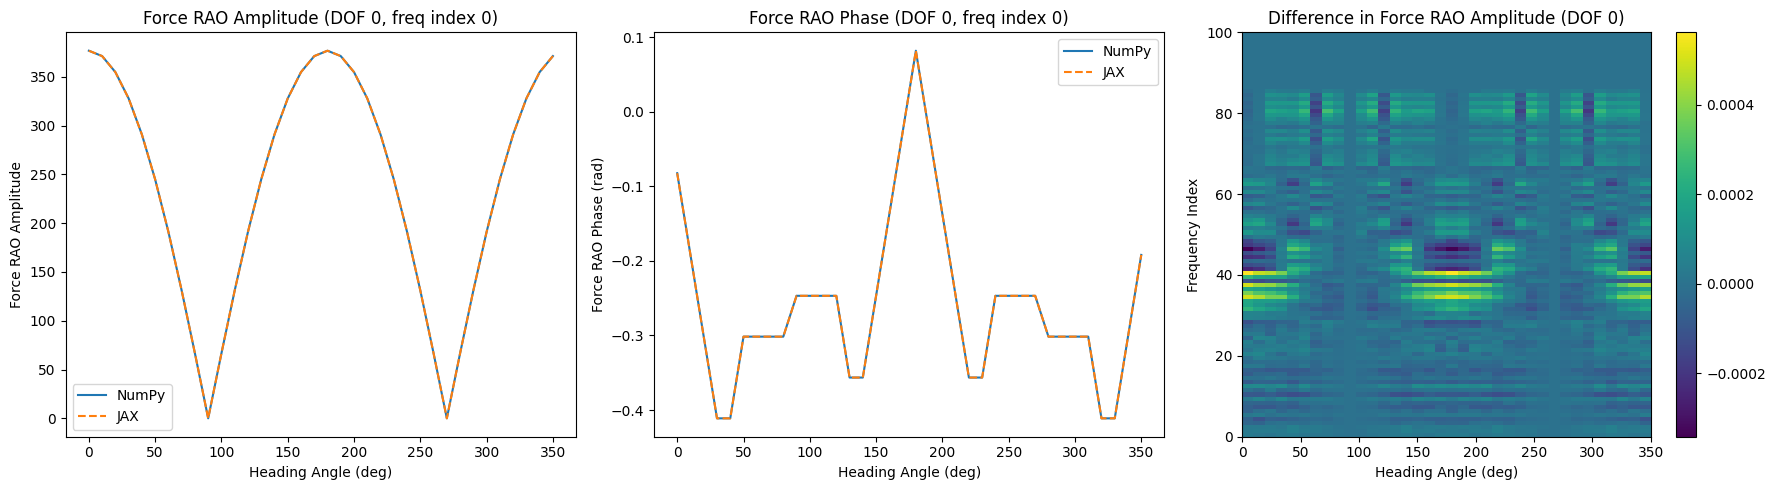

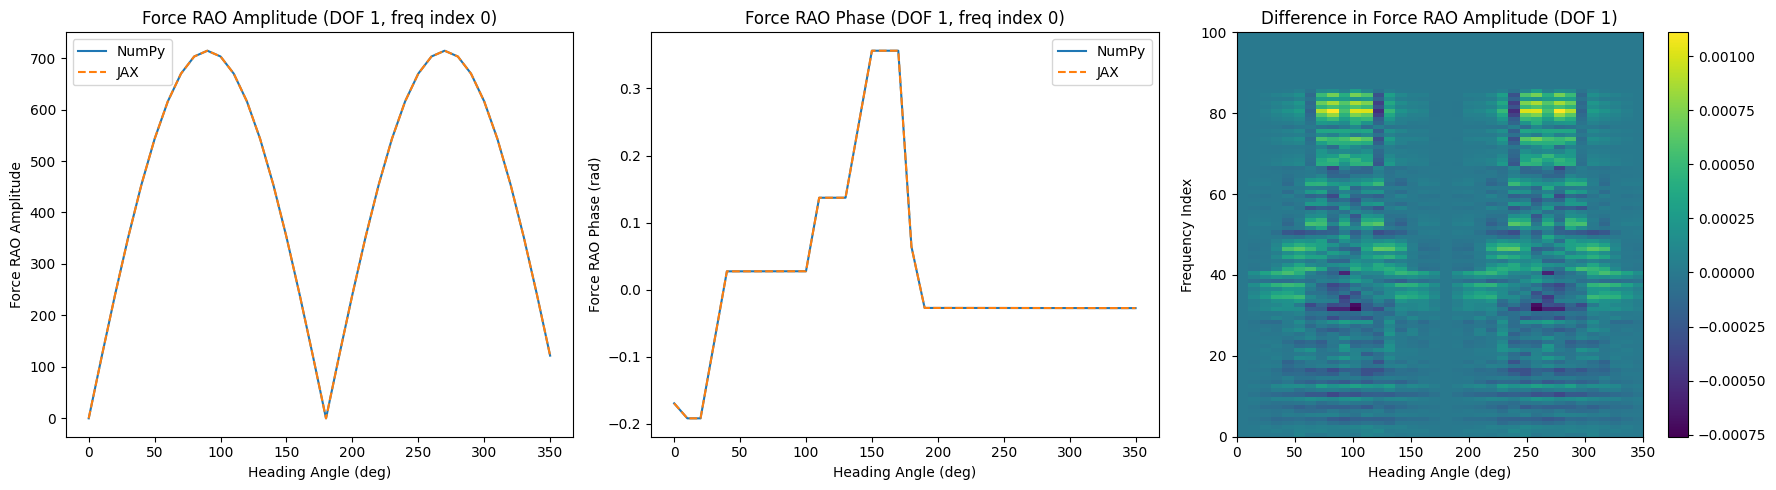

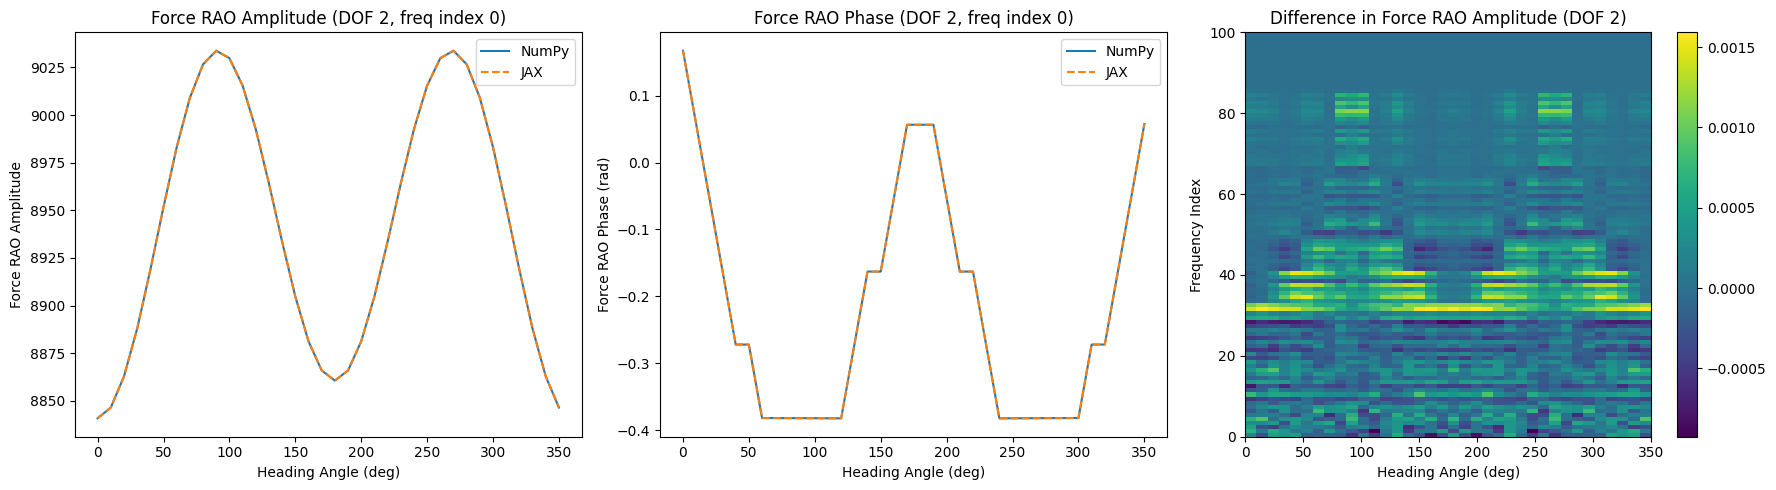

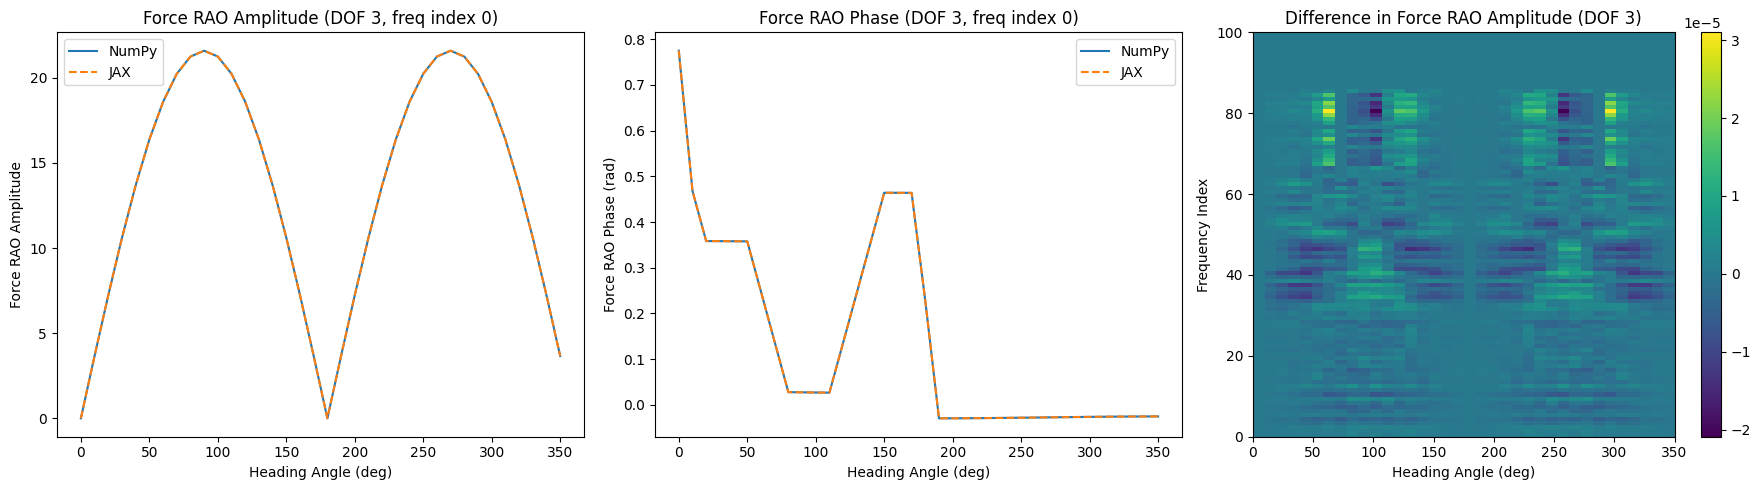

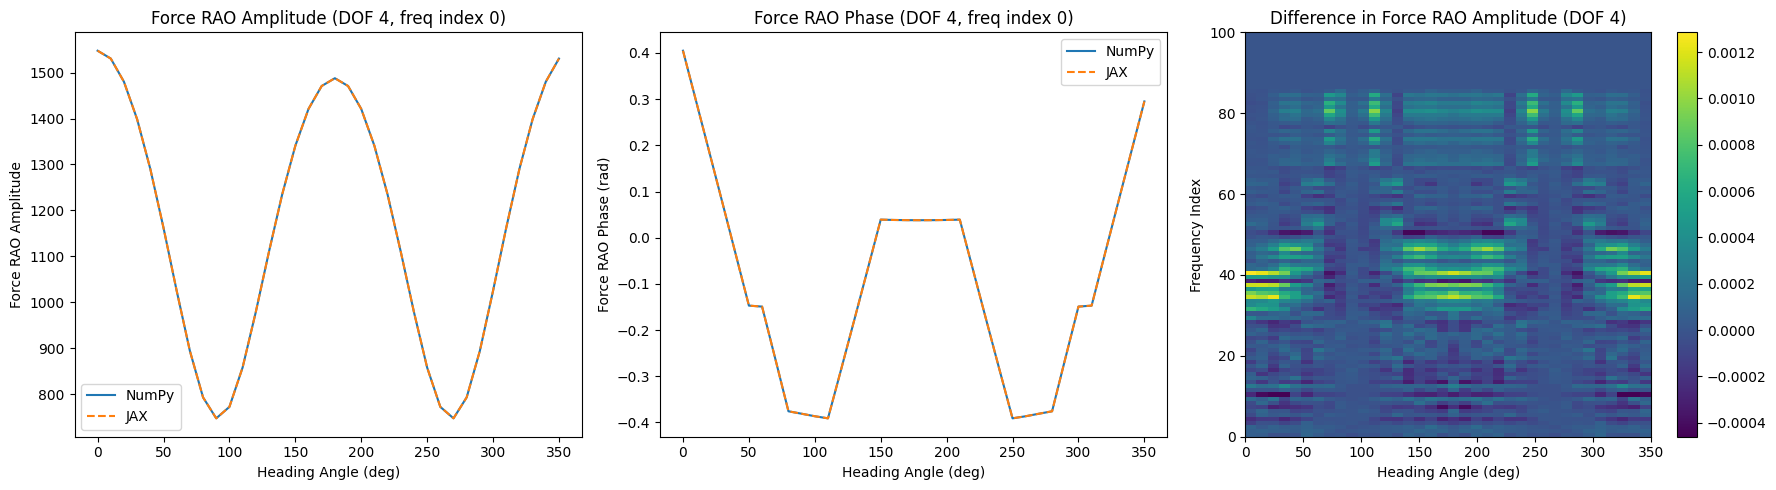

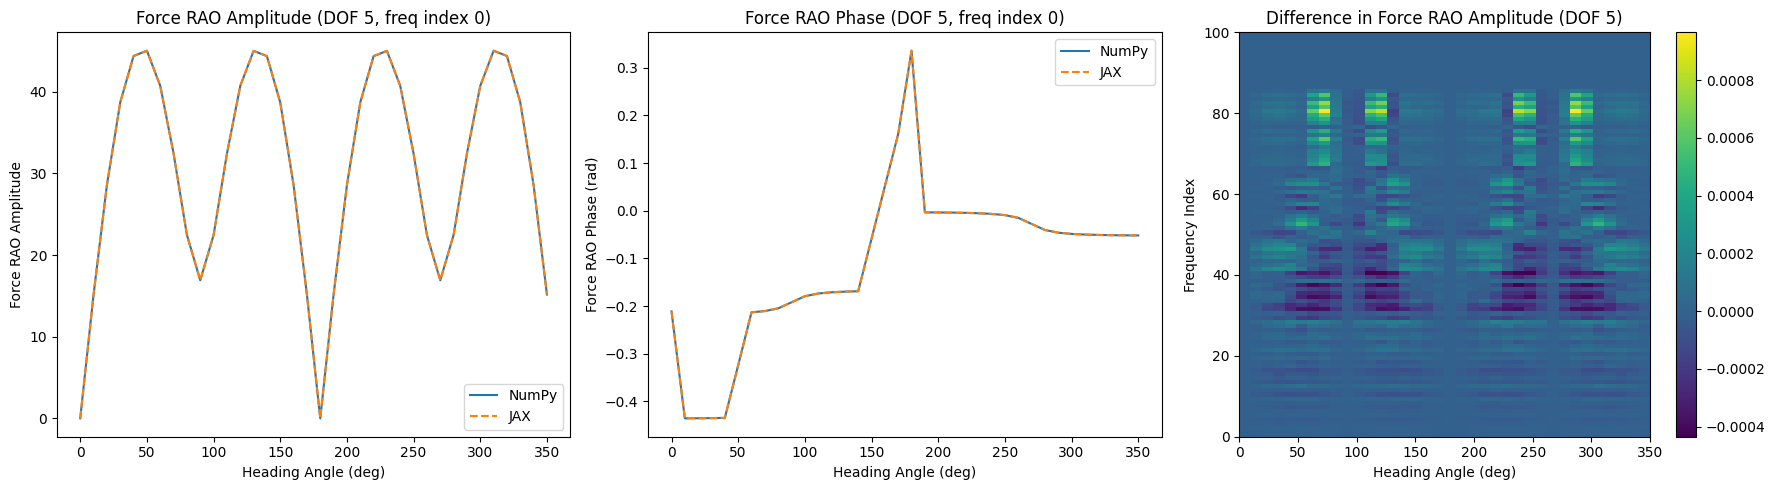

In [ ]:
# Get heading angles in degrees from the NumPy instance 
heading_angles = np.rad2deg(numpy_wl_geo._qtf_angles)  # e.g., 360 heading values

# Plot representative slices for all 6 DOFs
freq_index = round(2*np.pi/17)  # Example frequency index for a slice across heading angles

for dof in range(6):  # Loop over all 6 DOFs
    fig2, ax2 = plt.subplots(1, 3, figsize=(18, 5))
    
    # Force RAO Amplitude plot
    ax2[0].plot(heading_angles, np_forceRAOamp[dof, freq_index, :], label="NumPy")
    ax2[0].plot(heading_angles, jax_forceRAOamp[dof, freq_index, :], label="JAX", linestyle="--")
    ax2[0].set_title(f"Force RAO Amplitude (DOF {dof}, freq index {freq_index})")
    ax2[0].set_xlabel("Heading Angle (deg)")
    ax2[0].set_ylabel("Force RAO Amplitude")
    ax2[0].legend()
    
    # Force RAO Phase plot
    ax2[1].plot(heading_angles, np_forceRAOphase[dof, freq_index, :], label="NumPy")
    ax2[1].plot(heading_angles, jax_forceRAOphase[dof, freq_index, :], label="JAX", linestyle="--")
    ax2[1].set_title(f"Force RAO Phase (DOF {dof}, freq index {freq_index})")
    ax2[1].set_xlabel("Heading Angle (deg)")
    ax2[1].set_ylabel("Force RAO Phase (rad)")
    ax2[1].legend()
    
    # Difference in Force RAO Amplitude (all frequencies vs heading angles)
    # Use imshow with an extent based on heading_angles and frequency index
    # np_forceRAOamp[dof] is an array of shape (wave_freqs, heading_count)
    extent = [heading_angles[0], heading_angles[-1], 0, np_forceRAOamp[dof].shape[0]]
    im_diff = ax2[2].imshow(np_forceRAOamp[dof] - jax_forceRAOamp[dof], aspect="auto",
                            origin="lower", extent=extent)
    ax2[2].set_title(f"Difference in Force RAO Amplitude (DOF {dof})")
    ax2[2].set_xlabel("Heading Angle (deg)")
    ax2[2].set_ylabel("Frequency Index")
    plt.colorbar(im_diff, ax=ax2[2])
    
    plt.tight_layout()
    plt.show()



=== Comparing RAO Interpolation Outputs ===
RAO Interpolation Output Shapes:
  NumPy rao_amp: (6, 100) rao_phase: (6, 100)
  JAX   rao_amp: (6, 100) rao_phase: (6, 100)
RAO Amplitude Interpolation - Max difference: 0.0017764397698556422 Mean difference: 0.0002313938081929745
RAO Phase Interpolation - Max difference: 2.1500953317765692e-07 Mean difference: 7.107715311747744e-08


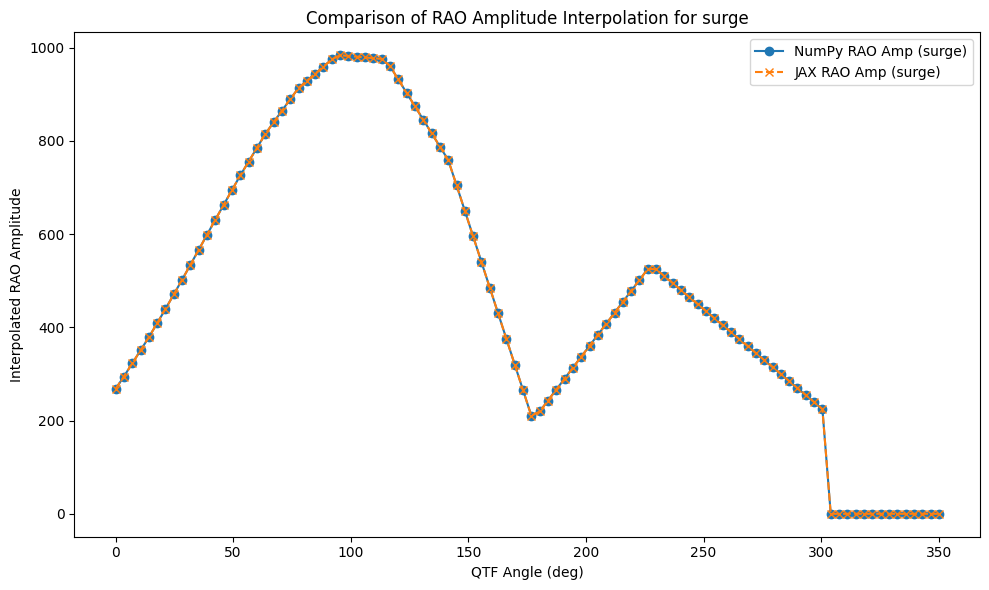

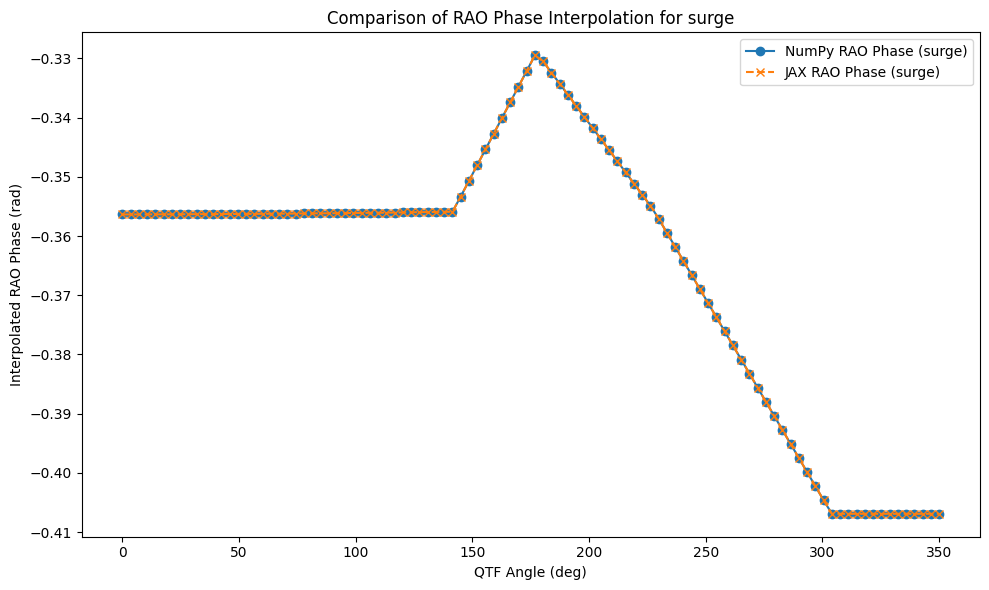

In [ ]:
# =============================================================================
# Compare RAO Interpolation Outputs
# =============================================================================

print("\n=== Comparing RAO Interpolation Outputs ===")

# For both implementations, we need a relative incident angle array.
# In the NumPy implementation, _relative_incident_angle is a method.
# Use a representative heading, for example, heading = 0 (radians).
heading_for_test = 0

# ----------------------------
# NumPy version: use the internal _relative_incident_angle and _rao_interp.
# ----------------------------
rel_angle_np = numpy_wl_geo._relative_incident_angle(heading_for_test)  
# This returns a vector of relative incident angles (one per wave component)
rao_amp_np_interp, rao_phase_np_interp = numpy_wl_geo._rao_interp(rel_angle_np)

# ----------------------------
# JAX version: use the functional equivalents.

# Compute the relative incident angle for the JAX implementation.
# Here, jax_wl.angles is a JAX array of the original wave incident angles.
rel_angle_jax = jax_relative_incident_angle(jax_wl_geo.angles, heading_for_test)
# Compute the RAO interpolation using the JAX function.
rao_amp_jax_interp, rao_phase_jax_interp = jax_rao_interp(jax_wl_geo.forceRAOamp,
                                                          jax_wl_geo.forceRAOphase,
                                                          jax_wl_geo.qtf_angles,
                                                          rel_angle_jax)
# Convert the JAX outputs to NumPy arrays for comparison.
rao_amp_jax_interp_np = np.array(rao_amp_jax_interp)
rao_phase_jax_interp_np = np.array(rao_phase_jax_interp)

# ----------------------------
# Compare the shapes.
# ----------------------------
print("RAO Interpolation Output Shapes:")
print("  NumPy rao_amp:", rao_amp_np_interp.shape, "rao_phase:", rao_phase_np_interp.shape)
print("  JAX   rao_amp:", rao_amp_jax_interp_np.shape, "rao_phase:", rao_phase_jax_interp_np.shape)

# ----------------------------
# Compute and print difference statistics.
# ----------------------------
rao_amp_diff = np.abs(rao_amp_np_interp - rao_amp_jax_interp_np)
rao_phase_diff = np.abs(rao_phase_np_interp - rao_phase_jax_interp_np)
print("RAO Amplitude Interpolation - Max difference:", np.max(rao_amp_diff),
      "Mean difference:", np.mean(rao_amp_diff))
print("RAO Phase Interpolation - Max difference:", np.max(rao_phase_diff),
      "Mean difference:", np.mean(rao_phase_diff))

# ----------------------------
# Plot a representative comparison for one DOF.
# ----------------------------
# Here, we plot the RAO amplitude as a function of the QTF angles (in radians)
qtf_angles_deg = np.rad2deg(numpy_wl_geo._qtf_angles)


# Interpolate qtf_angles_deg to 100 points to match the RAO amplitude arrays
interp_func = interp1d(np.linspace(0, 360, len(qtf_angles_deg)), qtf_angles_deg, kind="linear")
qtf_angles_deg_interp = interp_func(np.linspace(0, 360, rao_amp_np_interp.shape[1]))

plt.figure(figsize=(10, 6))
plt.plot(qtf_angles_deg_interp, rao_amp_np_interp[0, :], label="NumPy RAO Amp (surge)", marker="o")
plt.plot(qtf_angles_deg_interp, rao_amp_jax_interp_np[0, :], label="JAX RAO Amp (surge)", marker="x", linestyle="--")
plt.xlabel("QTF Angle (deg)")
plt.ylabel("Interpolated RAO Amplitude")
plt.title("Comparison of RAO Amplitude Interpolation for surge")
plt.legend()
plt.tight_layout()
plt.show()

# ----------------------------
# Plot the phase difference
# ----------------------------
plt.figure(figsize=(10, 6))
plt.plot(qtf_angles_deg_interp, rao_phase_np_interp[0, :], label="NumPy RAO Phase (surge)", marker="o")
plt.plot(qtf_angles_deg_interp, rao_phase_jax_interp_np[0, :], label="JAX RAO Phase (surge)", marker="x", linestyle="--")
plt.xlabel("QTF Angle (deg)")
plt.ylabel("Interpolated RAO Phase (rad)")
plt.title("Comparison of RAO Phase Interpolation for surge")
plt.legend()
plt.tight_layout()
plt.show()



In [95]:
# =============================================================================
# Compare First-Order Wave Loads over a range of time
# =============================================================================

# Create an array of time values (for example, 0 to 10 seconds, 100 points)
time_vals = np.linspace(0, 10, num=100)
eta_test = np.zeros(6)

# Compute first order loads for each time using the NumPy method.
np_first_order_loads = np.array([numpy_wl_geo.first_order_loads(t, eta_test) for t in time_vals])

# Compute first order loads for each time using the JAX method.
jax_first_order_loads_all = np.array([np.array(jax_first_order_loads(t, jnp.array(eta_test), jax_wl_geo))
                                      for t in time_vals])

print("\nFirst Order Wave Loads Comparison over time:")
print("NumPy First Order Loads shape:", np_first_order_loads.shape)
print("JAX   First Order Loads shape:", jax_first_order_loads_all.shape)



First Order Wave Loads Comparison over time:
NumPy First Order Loads shape: (100, 6)
JAX   First Order Loads shape: (100, 6)


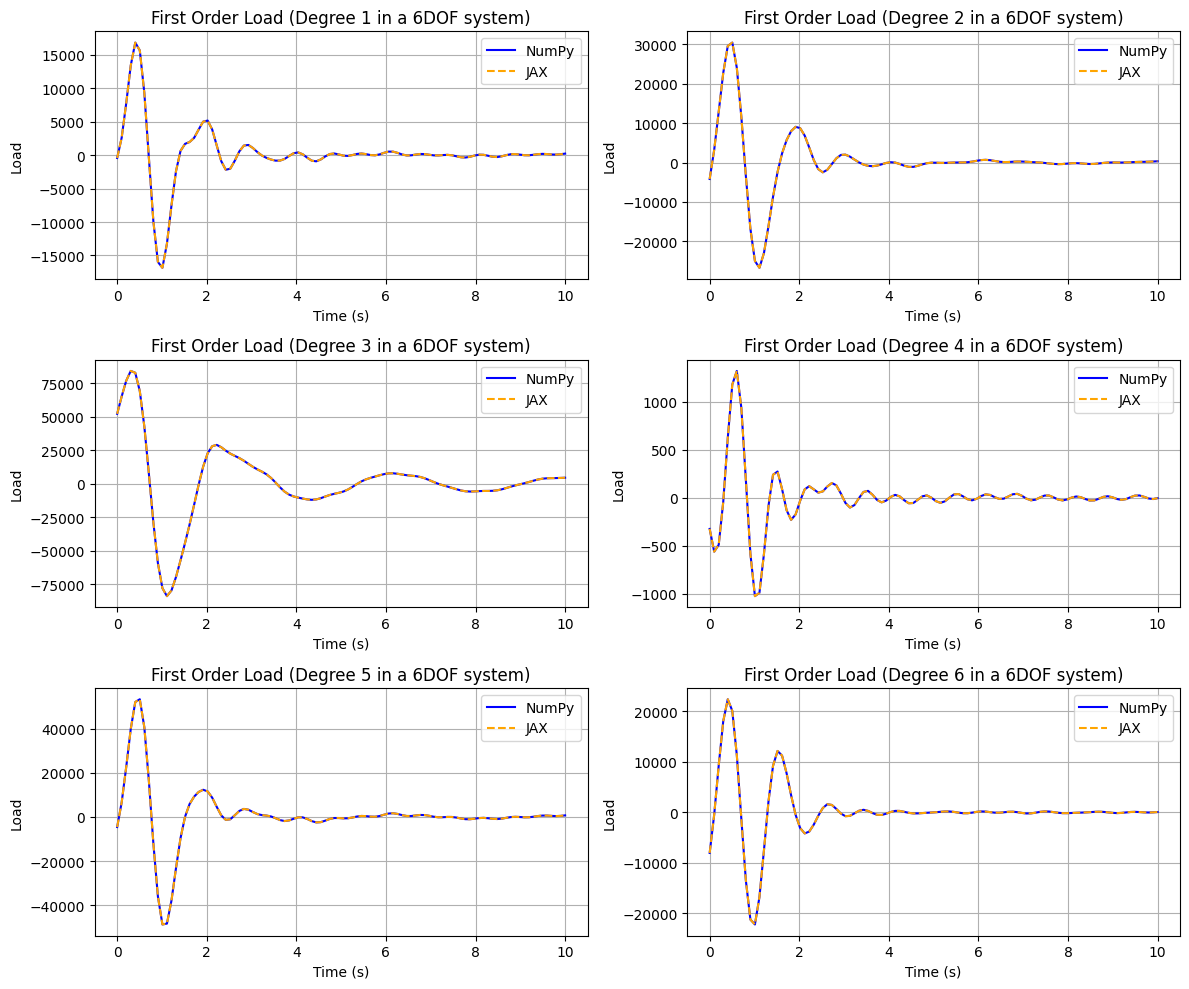

In [97]:
# plot the first order loads
fig, axes = plt.subplots(3, 2, figsize=(12, 10))
for i in range(3):
    for j in range(2):
        # Plot NumPy first order loads
        axes[i, j].plot(time_vals, np_first_order_loads[:, i*2+j], label="NumPy", color='blue')
        # Plot JAX first order loads
        axes[i, j].plot(time_vals, jax_first_order_loads_all[:, i*2+j], label="JAX", linestyle='--', color='orange')
        axes[i, j].set_title(f"First Order Load (Degree {i*2+j+1} in a 6DOF system)")
        axes[i, j].set_xlabel("Time (s)")
        axes[i, j].set_ylabel("Load")
        axes[i, j].legend()
        axes[i, j].grid()
plt.tight_layout()
plt.show()
# =============================================================================

In [71]:
# =============================================================================
# Compare Second-Order Wave Loads over a range of time
# =============================================================================

# Create an array of time values (for example, 0 to 10 seconds, 100 points)
time_vals = np.linspace(0, 10, num=100)
eta_test = np.zeros(6)

# Compute second order loads for each time using the NumPy method.
np_second_order_loads = np.array([numpy_wl_geo.second_order_loads(t, eta_test[-1]) for t in time_vals])

# Compute second order loads for each time using the JAX method.
jax_second_order_loads_all = np.array([np.array(jax_second_order_loads(t, jnp.array(eta_test[-1]), jax_wl_geo))
                                       for t in time_vals])

print("\nSecond Order Wave Loads Comparison over time:")
print("NumPy Second Order Loads shape:", np_second_order_loads.shape)
print("JAX   Second Order Loads shape:", jax_second_order_loads_all.shape)


Second Order Wave Loads Comparison over time:
NumPy Second Order Loads shape: (100, 6)
JAX   Second Order Loads shape: (100, 6)


## Description of Second-Order Wave Load Response
The observed load magnitude is likely elevated due to the absence of positional damping. However, when considering a rigid, non-deforming vertical pile subjected to waves with a significant wave height of 5 meters and a peak period of 9 seconds (Hs = 5 m, Tp = 9 s) with froude scaling factor 1/90, the resulting second-order wave loads appear inconsistent with theoretical expectations and are difficult to interpret. This might be wise to ask for guidance

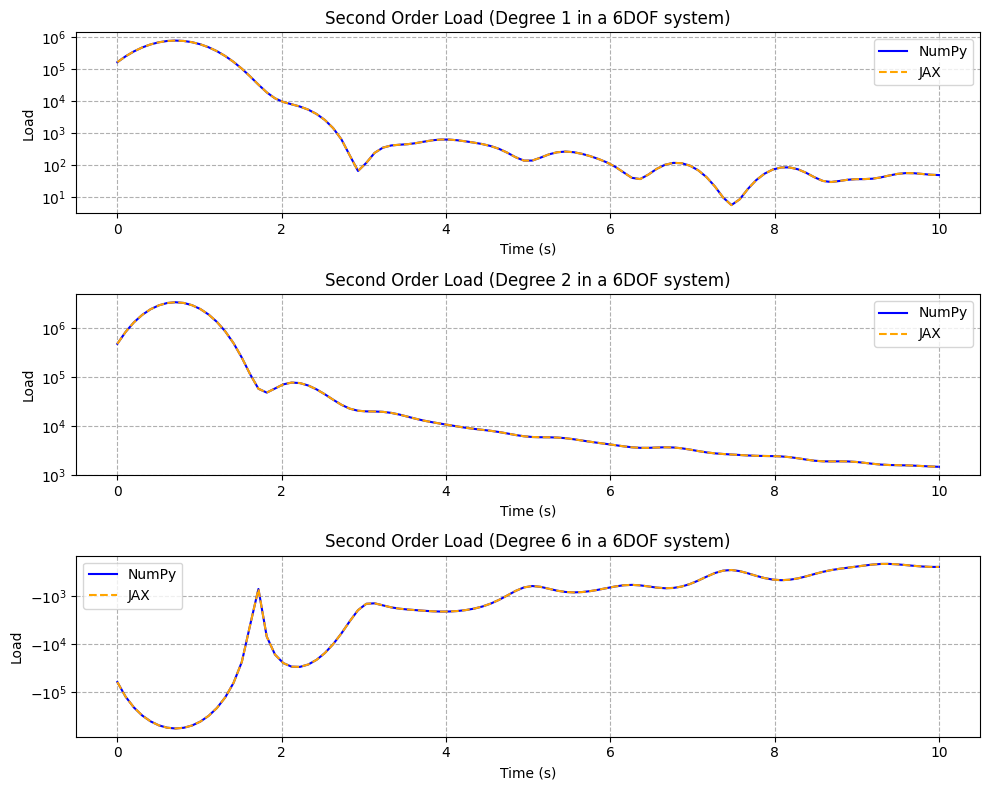

In [100]:
# Plot second order loads for DOFs 0, 1, and 5 with an improved scale using symlog.
dofs = [0, 1, 5]
fig, axes = plt.subplots(len(dofs), 1, figsize=(10, 8))
for idx, dof in enumerate(dofs):
    axes[idx].plot(time_vals, np_second_order_loads[:, dof], label="NumPy", color="blue")
    axes[idx].plot(time_vals, jax_second_order_loads_all[:, dof], label="JAX", linestyle="--", color="orange")
    axes[idx].set_title(f"Second Order Load (Degree {dof+1} in a 6DOF system)")
    axes[idx].set_xlabel("Time (s)")
    axes[idx].set_ylabel("Load")
    axes[idx].set_yscale("symlog", linthresh=1e-2)  # Adjust linthresh as needed for best fit.
    axes[idx].legend()
    axes[idx].grid(True, which="both", ls="--")
plt.tight_layout()
plt.show()


In [88]:
# =============================================================================
# wave_load comparison
# =============================================================================

# Compute first order loads for each time using the NumPy method.
np_wave_loads = np.array([numpy_wl_geo.__call__(t, eta_test) for t in time_vals])

# Compute first order loads for each time using the JAX method.
jax_wave_loads = np.array([np.array(jax_wave_load(t, jnp.array(eta_test), jax_wl_geo))
                                      for t in time_vals])

print("\nWave Loads Comparison over time:")
print("NumPy Wave Loads shape:", np_wave_loads.shape)
print("JAX   Wave Loads shape:", jax_wave_loads.shape)


Wave Loads Comparison over time:
NumPy Wave Loads shape: (100, 6)
JAX   Wave Loads shape: (100, 6)


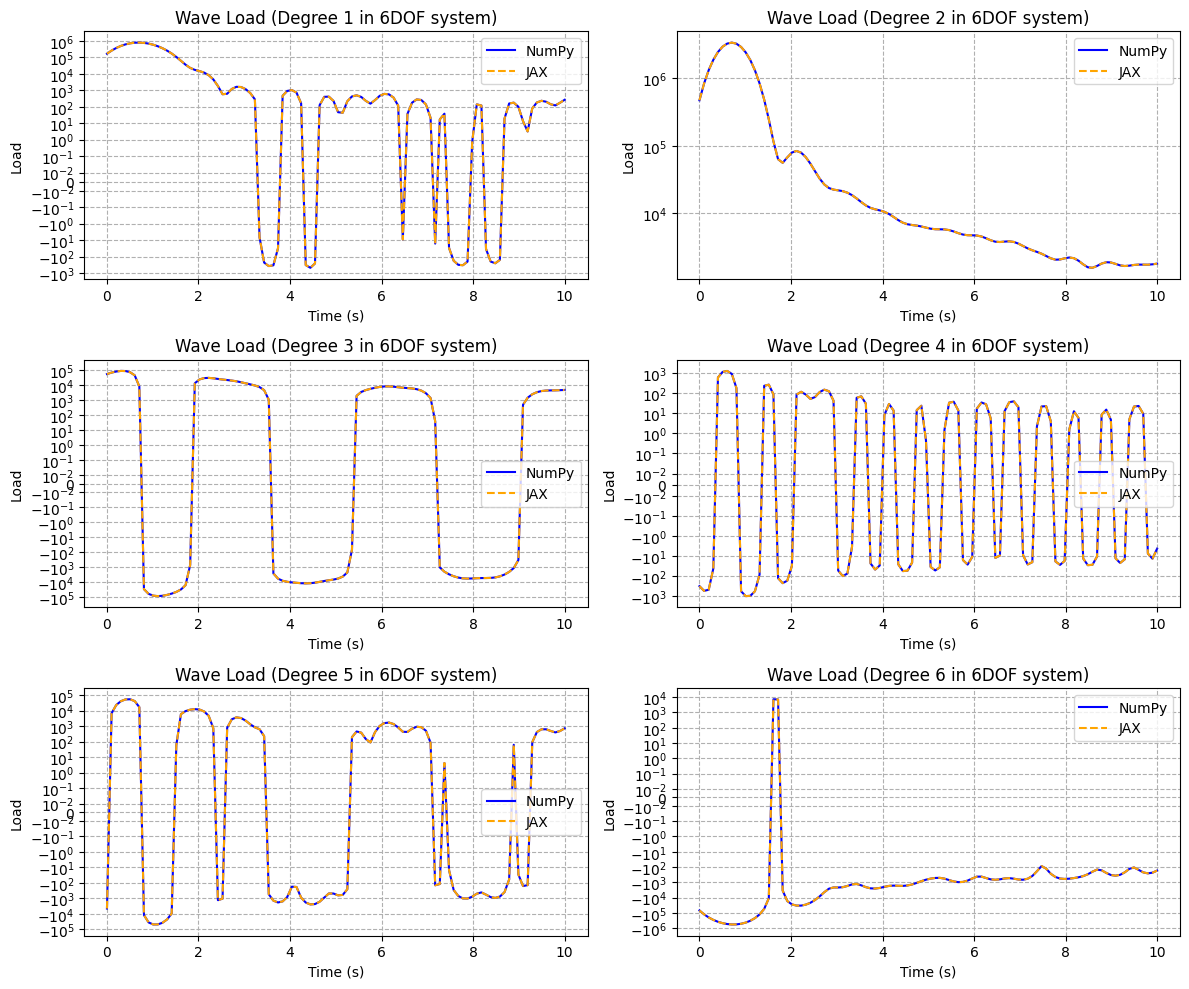

In [90]:
# plot the wave loads with a symmetric log scale for improved display
fig, axes = plt.subplots(3, 2, figsize=(12, 10))
for i in range(3):
    for j in range(2):
        # Plot NumPy wave loads over all time values
        axes[i, j].plot(time_vals, np_wave_loads[:, i*2+j], label="NumPy", color='blue')
        # Plot JAX wave loads over all time values
        axes[i, j].plot(time_vals, jax_wave_loads[:, i*2+j], label="JAX", linestyle='--', color='orange')
        axes[i, j].set_title(f"Wave Load (Degree {i*2+j+1} in 6DOF system)")
        axes[i, j].set_xlabel("Time (s)")
        axes[i, j].set_ylabel("Load")
        # Use a symmetric log scale with a linear threshold for small values
        axes[i, j].set_yscale("symlog", linthresh=1e-2, linscale=0.5)
        axes[i, j].legend()
        axes[i, j].grid(True, which="both", ls="--")
plt.tight_layout()
plt.show()
